Visualizing a few images from the CIFAR-10 dataset

100%|██████████| 170498071/170498071 [00:03<00:00, 52812428.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


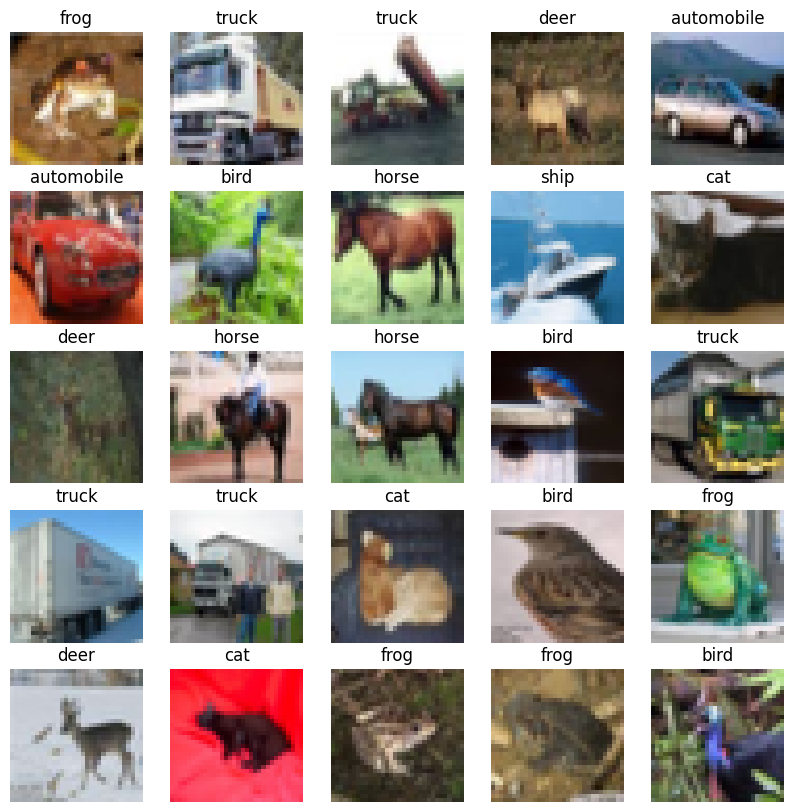

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Define the class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define a function to display a grid of images from the dataset
def display_images_grid(images, titles, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(np.transpose(images[i*cols+j].numpy(), (1, 2, 0)))
            axs[i,j].set_title(class_names[titles[i*cols+j]])
            axs[i,j].axis('off')
    plt.show()

# Display a grid of 25 images from the dataset
images = []
titles = []
for i in range(25):
    image, label = cifar_dataset[i]
    images.append(image)
    titles.append(label)
display_images_grid(images, titles, 5, 5)

'DatasetFetcher' allows fetching and preparing data loaders for the CIFAR-10 dataset using PyTorch's DataLoader class. The class supports data augmentation and normalization. The data augmentation consists of random horizontal flip, random crop, and equalization of the image. The normalization is based on the mean and standard deviation of the training dataset. The code initializes the 'DatasetFetcher' object, adds data augmentation and normalization, and retrieves the training and testing data loaders. The batch_size parameter specifies the number of samples per batch, while size and padding parameters in dataAugmentation method control the size and padding of the random crop.

In [2]:
import torch
import multiprocessing
import torchvision
# import numpy as np
from torch.utils.data import DataLoader

class DatasetFetcher:
    
    def __init__(self, dataset="CIFAR10", batch_size=128):
        # Initialize the class with the specified dataset name and batch size
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.train_transformers = []
        self.test_transformers = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)

    def augmentData(self):
        # Add a transformer that randomly flips the image horizontally during training
        self.train_transformers.append(torchvision.transforms.RandomHorizontalFlip())
        # Add a transformer that randomly crops the image during training
        self.train_transformers.append(torchvision.transforms.RandomCrop(size=32, padding=3))
        # Add a transformer that equalizes the histogram of the image during both training and testing
        self.train_transformers.append(torchvision.transforms.functional.equalize)
        self.test_transformers.append(torchvision.transforms.functional.equalize)

    def __addToTensor(self):
        # Helper function to add a transformer that converts the image to a tensor during both training and testing
        self.train_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.ToTensor())
        
    def __loadTrainNormalizers(self):
        # Helper function to load the mean and standard deviation of the training dataset
        params = np.load("./trainNormalizedParameters.npz")
        return params['mean'], params['std']

    def addNormalizer(self):
        # Add a transformer that normalizes the image during both training and testing
        self.__addToTensor()
        trainingDataset = self.datasetObject(root="./data", train=True, download=True)
        trainData = trainingDataset.data/255.0
        mean = trainData.mean(axis=(0, 1, 2))
        std = trainData.std(axis=(0, 1, 2))
        np.savez("./trainNormalizedParameters", mean=mean, std=std)
        self.train_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
 
        # function to get train and test loaders
    def getLoaders(self):
        # check if train transformers are empty and add 'ToTensor' transformer
        if len(self.train_transformers) == 0:
            self.__addToTensor()
            
        # create training dataset using the 'train_transformers'
        train_dataset = self.datasetObject(
            root="./data", train=True, download=True,
            transform=torchvision.transforms.Compose(self.train_transformers)
        )
        
        # create testing dataset using the 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create train loader using the training dataset
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=self.workersAvailable
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return train_loader, test_loader

    # function to get test loader
    def getTestLoader(self):
        # get mean and std dev of train dataset
        mean, std = self.__loadTrainNormalizers()
        
        # append 'ToTensor' and 'Normalize' transformers to 'test_transformers'
        self.test_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        
        # create testing dataset using the updated 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return test_loader

# main code block
if __name__ == "__main__":
    # create an instance of DatasetFetcher class with CIFAR10 dataset and batch size of 128
    df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
    
    # add transformations to the dataset
    df.augmentData()
    df.addNormalizer()
    
    # get train and test loaders using the added transformations
    train_loader, test_loader = df.getLoaders()

   

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



Worked on the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py \\
C - Number of channels \\
F - Filter size \\
K - Kernel size \\
P - Pool size \\

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
         # Batch normalization layer after the first convolution
        self.bn1 = nn.BatchNorm2d(planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        # Batch normalization layer after the second convolution
        self.bn2 = nn.BatchNorm2d(planes)

         # Shortcuts are used to add the input to the output of the residual block
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
           # If the input and output dimensions are not the same, use a convolutional layer to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
      # Apply the first convolutional layer, followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the second convolutional layer, followed by batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
         # Apply ReLU activation to the output
        out = F.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
      # Call the superclass constructor to initialize the nn.Module
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

         # Create the first convolutional layer and batch normalization layer
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        # Create the remaining layers using the specified number of blocks
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        # Create the output layer
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        # Set the path to save the model
        self.path = "./saved_model.pt"
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Create a list of strides for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        # Create each block in the layer
        for stride in strides:
           # Append the block to the list of blocks in the layer
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            # Update the number of input channels for the next bloc
            self.in_planes = planes
            # Return the layer as a sequential module
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the remaining layers in the network
        for layer in self.layers:
            out = layer(out)
        # Apply average pooling with kernel size P
        out = F.avg_pool2d(out, self.P)
        # Flatten the output tensor
        out = out.view(out.size(0), -1)
        # Apply the final linear layer to produce the output tensor
        out = self.linear(out)
        # Return the output tensor
        return out

     #Define a function to save the model to disk
    def saveToDisk(self):
      torch.save(self.state_dict(), self.path)

    #Define a function to load the model from disk
    def loadFromDisk(self):
      self.load_state_dict(torch.load(self.path))

def resnet_model():
  B=[3,3,2,3]
  C=[64,128,128,256]
  F=[3,3,3,3]
  K=[1,1,1,1]
  P=4
  N=len(B)

  return ResNet(N, B, C, F, K, P)

In [4]:
import torch
# Set random seed to ensure reproducibility
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
model = resnet_model()
model = model.to(device)
# Count the number of trainable parameters in the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Print the number of trainable parameters
print("Number of trainable parameters:",trainable_parameters)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
Number of trainable parameters: 4935242


To determine the model's best accuracy, we run it for 300 epochs. After that, accuracy becomes almost constant. We specify the following parameters: learning rate, weight decay, and kind of optimizer to be employed (Adam, Adagrad, and AdaDelta), with Adadelta providing the greatest accuracy. A cosine annealing scheduler was used to determine the learning rate for each parameter group.

In [6]:
# Define number of epochs
EPOCHS = 300
# Initialize global best accuracy
globalBestAccuracy = 0.0
# Create empty lists to store training and testing losses and accuracies
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [7]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.001
weightDecay = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Number of Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model parameters are out of range")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Now we train and test the model for 300 epochs.

In [8]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

# Training loop
for i in tqdm(range(EPOCHS)):   # Loop over the number of epochs
    for phase in ['train', 'test']:  # Loop over the training and test phases
        if phase == "train": # Set the loader and model mode based on the phase
            loader = train_loader
            model,optimizer= train(model,loader,optimizer)
        else:
            loader = test_loader
            #test
            model.eval()
        runningLoss = 0.0  # Initialize the running loss and corrects
        runningCorrects = 0
        for images, labels in loader:  # Loop over the batches of data
            images = images.to(device)  # Move images and labels to device
            labels = labels.to(device)
            output = model(images)  # Forward pass through the model
            loss = lossFunction(output, labels)  # Compute the loss
            predicted_labels = torch.argmax(output, dim=1)  # Get the predicted labels
            runningLoss += loss.item()  # Update the running loss and corrects
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":  # Backward pass and optimization for training phase
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)  # Compute the epoch loss and accuracy
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":  # Update the scheduler and training statistics
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:  # Update the testing statistics and save the model if it is the best so far
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    # Print the statistics for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))


  0%|          | 1/300 [00:17<1:28:59, 17.86s/it]

Training Loss : 2.9292684344482423, Testing Loss : 6.276963600158691, Training Accuracy : 0.10858, Testing Accuracy : 0.1065


  1%|          | 2/300 [00:28<1:07:30, 13.59s/it]

Training Loss : 2.3199002780151368, Testing Loss : 2.3157274364471436, Training Accuracy : 0.1011, Testing Accuracy : 0.1094


  1%|          | 3/300 [00:39<1:00:46, 12.28s/it]

Training Loss : 2.299977067871094, Testing Loss : 2.2986545959472657, Training Accuracy : 0.10698, Testing Accuracy : 0.1126


  1%|▏         | 4/300 [00:50<58:04, 11.77s/it]  

Training Loss : 2.2902474710083007, Testing Loss : 2.2748019401550295, Training Accuracy : 0.11334, Testing Accuracy : 0.1119


  2%|▏         | 5/300 [01:01<56:45, 11.55s/it]

Training Loss : 2.2413389877319334, Testing Loss : 2.26074871635437, Training Accuracy : 0.14242, Testing Accuracy : 0.1427


  2%|▏         | 6/300 [01:12<55:40, 11.36s/it]

Training Loss : 2.1766061813354494, Testing Loss : 2.1692302925109863, Training Accuracy : 0.17254, Testing Accuracy : 0.1757


  2%|▏         | 7/300 [01:22<54:01, 11.06s/it]

Training Loss : 2.1055902407836915, Testing Loss : 2.0455198570251465, Training Accuracy : 0.19962, Testing Accuracy : 0.2145


  3%|▎         | 8/300 [01:33<53:01, 10.90s/it]

Training Loss : 2.0613511611938478, Testing Loss : 2.067866697502136, Training Accuracy : 0.21402, Testing Accuracy : 0.2141


  3%|▎         | 9/300 [01:43<52:21, 10.79s/it]

Training Loss : 2.007794563293457, Testing Loss : 2.001579835891724, Training Accuracy : 0.23922, Testing Accuracy : 0.2437


  3%|▎         | 10/300 [01:54<52:05, 10.78s/it]

Training Loss : 1.977877557373047, Testing Loss : 2.005648849105835, Training Accuracy : 0.2649, Testing Accuracy : 0.2737


  4%|▎         | 11/300 [02:05<51:42, 10.74s/it]

Training Loss : 1.9298601434326172, Testing Loss : 1.9797325469970704, Training Accuracy : 0.2952, Testing Accuracy : 0.278


  4%|▍         | 12/300 [02:15<51:12, 10.67s/it]

Training Loss : 1.918268268737793, Testing Loss : 1.9282747774124145, Training Accuracy : 0.2931, Testing Accuracy : 0.2847


  4%|▍         | 13/300 [02:26<50:52, 10.64s/it]

Training Loss : 1.8333369549560548, Testing Loss : 1.881561822128296, Training Accuracy : 0.32412, Testing Accuracy : 0.3027


  5%|▍         | 14/300 [02:36<50:25, 10.58s/it]

Training Loss : 1.8411672512817383, Testing Loss : 1.8808695791244507, Training Accuracy : 0.32512, Testing Accuracy : 0.2998


  5%|▌         | 15/300 [02:47<50:18, 10.59s/it]

Training Loss : 1.8031492623901366, Testing Loss : 1.8396363182067872, Training Accuracy : 0.33748, Testing Accuracy : 0.3282


  5%|▌         | 16/300 [02:58<50:15, 10.62s/it]

Training Loss : 1.7270959951782228, Testing Loss : 1.7634299896240235, Training Accuracy : 0.36648, Testing Accuracy : 0.3484


  6%|▌         | 17/300 [03:08<49:53, 10.58s/it]

Training Loss : 1.6717702374267578, Testing Loss : 1.697671736907959, Training Accuracy : 0.38758, Testing Accuracy : 0.3913


  6%|▌         | 18/300 [03:19<49:39, 10.56s/it]

Training Loss : 1.6661220867919921, Testing Loss : 1.7567969552993774, Training Accuracy : 0.3886, Testing Accuracy : 0.3666


  6%|▋         | 19/300 [03:29<49:23, 10.55s/it]

Training Loss : 1.5687318634033203, Testing Loss : 1.5230283638000488, Training Accuracy : 0.4329, Testing Accuracy : 0.4566


  7%|▋         | 20/300 [03:40<49:00, 10.50s/it]

Training Loss : 1.4726712202453613, Testing Loss : 1.512480055809021, Training Accuracy : 0.4725, Testing Accuracy : 0.451


  7%|▋         | 21/300 [03:50<48:49, 10.50s/it]

Training Loss : 1.4516215112304687, Testing Loss : 1.4604553607940673, Training Accuracy : 0.48742, Testing Accuracy : 0.4761


  7%|▋         | 22/300 [04:01<48:44, 10.52s/it]

Training Loss : 1.3713810888671876, Testing Loss : 1.5201395452499389, Training Accuracy : 0.51272, Testing Accuracy : 0.4808


  8%|▊         | 23/300 [04:11<48:36, 10.53s/it]

Training Loss : 1.3718948054504394, Testing Loss : 1.4465261110305787, Training Accuracy : 0.50586, Testing Accuracy : 0.4679


  8%|▊         | 24/300 [04:22<48:27, 10.54s/it]

Training Loss : 1.3455288800048828, Testing Loss : 1.4180381372451782, Training Accuracy : 0.52012, Testing Accuracy : 0.5084


  8%|▊         | 25/300 [04:32<48:20, 10.55s/it]

Training Loss : 1.3017363612365722, Testing Loss : 1.5339548414230346, Training Accuracy : 0.54196, Testing Accuracy : 0.4695


  9%|▊         | 26/300 [04:43<48:06, 10.53s/it]

Training Loss : 1.2384061911010742, Testing Loss : 1.315890817451477, Training Accuracy : 0.56036, Testing Accuracy : 0.5424


  9%|▉         | 27/300 [04:53<48:06, 10.57s/it]

Training Loss : 1.1733778666687011, Testing Loss : 1.3590002058029176, Training Accuracy : 0.58154, Testing Accuracy : 0.5354


  9%|▉         | 28/300 [05:04<47:41, 10.52s/it]

Training Loss : 1.189374920501709, Testing Loss : 1.224339706993103, Training Accuracy : 0.58182, Testing Accuracy : 0.577


 10%|▉         | 29/300 [05:14<47:38, 10.55s/it]

Training Loss : 1.1113123350524903, Testing Loss : 1.1497527254104614, Training Accuracy : 0.60742, Testing Accuracy : 0.6067


 10%|█         | 30/300 [05:25<47:31, 10.56s/it]

Training Loss : 1.0633175036621094, Testing Loss : 1.1269910964965821, Training Accuracy : 0.62554, Testing Accuracy : 0.603


 10%|█         | 31/300 [05:36<47:29, 10.59s/it]

Training Loss : 1.0582055589294435, Testing Loss : 1.1385495922088622, Training Accuracy : 0.62938, Testing Accuracy : 0.6143


 11%|█         | 32/300 [05:46<47:15, 10.58s/it]

Training Loss : 1.0394783158874512, Testing Loss : 1.1321287326812743, Training Accuracy : 0.63774, Testing Accuracy : 0.6074


 11%|█         | 33/300 [05:57<47:14, 10.62s/it]

Training Loss : 1.0383633921051025, Testing Loss : 1.0381515125274658, Training Accuracy : 0.63592, Testing Accuracy : 0.6319


 11%|█▏        | 34/300 [06:07<46:54, 10.58s/it]

Training Loss : 0.9446821603393555, Testing Loss : 0.9842937781333924, Training Accuracy : 0.6707, Testing Accuracy : 0.6641


 12%|█▏        | 35/300 [06:18<46:43, 10.58s/it]

Training Loss : 0.9145269004821778, Testing Loss : 0.9636398021697998, Training Accuracy : 0.683, Testing Accuracy : 0.6748


 12%|█▏        | 36/300 [06:29<46:28, 10.56s/it]

Training Loss : 0.8989735827636719, Testing Loss : 0.9916427801132203, Training Accuracy : 0.68936, Testing Accuracy : 0.6671


 12%|█▏        | 37/300 [06:39<46:11, 10.54s/it]

Training Loss : 0.9174388798522949, Testing Loss : 1.0098415232658386, Training Accuracy : 0.68168, Testing Accuracy : 0.6502


 13%|█▎        | 38/300 [06:50<46:01, 10.54s/it]

Training Loss : 0.8892449801635742, Testing Loss : 0.9710292289733887, Training Accuracy : 0.69372, Testing Accuracy : 0.68


 13%|█▎        | 39/300 [07:00<45:51, 10.54s/it]

Training Loss : 0.859968631286621, Testing Loss : 0.8867899862289429, Training Accuracy : 0.70388, Testing Accuracy : 0.7002


 13%|█▎        | 40/300 [07:11<45:44, 10.56s/it]

Training Loss : 0.809000125579834, Testing Loss : 0.8823059116363525, Training Accuracy : 0.72232, Testing Accuracy : 0.7043


 14%|█▎        | 41/300 [07:21<45:39, 10.58s/it]

Training Loss : 0.7909986451721192, Testing Loss : 0.8393539574623108, Training Accuracy : 0.72588, Testing Accuracy : 0.7076


 14%|█▍        | 42/300 [07:32<45:36, 10.61s/it]

Training Loss : 0.7765214665222168, Testing Loss : 0.8286188426017761, Training Accuracy : 0.73426, Testing Accuracy : 0.7209


 14%|█▍        | 43/300 [07:42<45:14, 10.56s/it]

Training Loss : 0.7498399870300293, Testing Loss : 0.8787515087127685, Training Accuracy : 0.74196, Testing Accuracy : 0.7003


 15%|█▍        | 44/300 [07:53<45:08, 10.58s/it]

Training Loss : 0.7849656171417236, Testing Loss : 0.836221813583374, Training Accuracy : 0.72914, Testing Accuracy : 0.7202


 15%|█▌        | 45/300 [08:04<45:02, 10.60s/it]

Training Loss : 0.7219455166625977, Testing Loss : 0.7920529950141907, Training Accuracy : 0.75194, Testing Accuracy : 0.7359


 15%|█▌        | 46/300 [08:14<44:51, 10.60s/it]

Training Loss : 0.6850529512023926, Testing Loss : 0.8443204390525818, Training Accuracy : 0.76468, Testing Accuracy : 0.7194


 16%|█▌        | 47/300 [08:25<44:36, 10.58s/it]

Training Loss : 0.7197836665344238, Testing Loss : 0.8026129779815674, Training Accuracy : 0.75124, Testing Accuracy : 0.7347


 16%|█▌        | 48/300 [08:35<44:24, 10.57s/it]

Training Loss : 0.6746228549194336, Testing Loss : 0.7205748444080353, Training Accuracy : 0.7696, Testing Accuracy : 0.7597


 16%|█▋        | 49/300 [08:46<43:55, 10.50s/it]

Training Loss : 0.6256346137237548, Testing Loss : 0.8243320328712463, Training Accuracy : 0.78162, Testing Accuracy : 0.7245


 17%|█▋        | 50/300 [08:56<43:50, 10.52s/it]

Training Loss : 0.6423747498321534, Testing Loss : 0.7155971709251404, Training Accuracy : 0.77958, Testing Accuracy : 0.7608


 17%|█▋        | 51/300 [09:07<43:49, 10.56s/it]

Training Loss : 0.6084863240051269, Testing Loss : 0.7024272423744201, Training Accuracy : 0.79442, Testing Accuracy : 0.7634


 17%|█▋        | 52/300 [09:18<43:52, 10.62s/it]

Training Loss : 0.5838768318939209, Testing Loss : 0.7215265025615692, Training Accuracy : 0.79908, Testing Accuracy : 0.765


 18%|█▊        | 53/300 [09:29<43:59, 10.69s/it]

Training Loss : 0.6124775006103516, Testing Loss : 0.7661948292732239, Training Accuracy : 0.79108, Testing Accuracy : 0.7449


 18%|█▊        | 54/300 [09:39<43:34, 10.63s/it]

Training Loss : 0.5802401206207275, Testing Loss : 0.6907777417182922, Training Accuracy : 0.80236, Testing Accuracy : 0.7731


 18%|█▊        | 55/300 [09:50<43:18, 10.61s/it]

Training Loss : 0.5352282405090332, Testing Loss : 0.632189262676239, Training Accuracy : 0.81502, Testing Accuracy : 0.7902


 19%|█▊        | 56/300 [10:00<43:02, 10.58s/it]

Training Loss : 0.532417142944336, Testing Loss : 0.6912334816932678, Training Accuracy : 0.8176, Testing Accuracy : 0.7781


 19%|█▉        | 57/300 [10:11<42:43, 10.55s/it]

Training Loss : 0.5409007038116455, Testing Loss : 0.6739093183517456, Training Accuracy : 0.81438, Testing Accuracy : 0.7795


 19%|█▉        | 58/300 [10:21<42:39, 10.58s/it]

Training Loss : 0.51260916847229, Testing Loss : 0.5973587287902832, Training Accuracy : 0.82396, Testing Accuracy : 0.8003


 20%|█▉        | 59/300 [10:32<42:42, 10.63s/it]

Training Loss : 0.48654693813323974, Testing Loss : 0.5899257342338562, Training Accuracy : 0.83116, Testing Accuracy : 0.8008


 20%|██        | 60/300 [10:43<42:32, 10.64s/it]

Training Loss : 0.4915211827850342, Testing Loss : 58.85524025878906, Training Accuracy : 0.83096, Testing Accuracy : 0.1133


 20%|██        | 61/300 [10:53<42:15, 10.61s/it]

Training Loss : 0.4973381636810303, Testing Loss : 0.7243485223770142, Training Accuracy : 0.8286, Testing Accuracy : 0.7707


 21%|██        | 62/300 [11:04<41:59, 10.59s/it]

Training Loss : 0.5175126548767089, Testing Loss : 0.6751350907325745, Training Accuracy : 0.82488, Testing Accuracy : 0.7849


 21%|██        | 63/300 [11:14<41:44, 10.57s/it]

Training Loss : 0.5270468853759765, Testing Loss : 0.629036047744751, Training Accuracy : 0.8201, Testing Accuracy : 0.7903


 21%|██▏       | 64/300 [11:25<41:36, 10.58s/it]

Training Loss : 0.481206054725647, Testing Loss : 0.6120724491119385, Training Accuracy : 0.8353, Testing Accuracy : 0.7939


 22%|██▏       | 65/300 [11:36<41:30, 10.60s/it]

Training Loss : 0.4452505419921875, Testing Loss : 0.5723389624595642, Training Accuracy : 0.8464, Testing Accuracy : 0.8101


 22%|██▏       | 66/300 [11:46<41:31, 10.65s/it]

Training Loss : 0.44311788833618165, Testing Loss : 0.5870328211307526, Training Accuracy : 0.84808, Testing Accuracy : 0.8075


 22%|██▏       | 67/300 [11:57<41:25, 10.67s/it]

Training Loss : 0.4367000444412231, Testing Loss : 0.6386362151145935, Training Accuracy : 0.84998, Testing Accuracy : 0.7973


 23%|██▎       | 68/300 [12:08<41:06, 10.63s/it]

Training Loss : 0.4311695568847656, Testing Loss : 0.6130991173267365, Training Accuracy : 0.85108, Testing Accuracy : 0.8048


 23%|██▎       | 69/300 [12:18<40:50, 10.61s/it]

Training Loss : 0.4408470699310303, Testing Loss : 0.666058251285553, Training Accuracy : 0.84916, Testing Accuracy : 0.7856


 23%|██▎       | 70/300 [12:29<40:27, 10.56s/it]

Training Loss : 0.44356841796875, Testing Loss : 0.6281425288200378, Training Accuracy : 0.84876, Testing Accuracy : 0.8017


 24%|██▎       | 71/300 [12:39<40:14, 10.54s/it]

Training Loss : 0.4136755424499512, Testing Loss : 0.5326791175365448, Training Accuracy : 0.85864, Testing Accuracy : 0.8234


 24%|██▍       | 72/300 [12:50<40:17, 10.60s/it]

Training Loss : 0.37699296157836915, Testing Loss : 0.5855416977405548, Training Accuracy : 0.86966, Testing Accuracy : 0.813


 24%|██▍       | 73/300 [13:00<40:02, 10.58s/it]

Training Loss : 0.3848217667388916, Testing Loss : 0.5903079095840454, Training Accuracy : 0.86766, Testing Accuracy : 0.807


 25%|██▍       | 74/300 [13:11<39:58, 10.61s/it]

Training Loss : 0.3919658940124512, Testing Loss : 0.7128992504119873, Training Accuracy : 0.86502, Testing Accuracy : 0.7823


 25%|██▌       | 75/300 [13:22<39:46, 10.61s/it]

Training Loss : 0.4021747036743164, Testing Loss : 0.5700599805116654, Training Accuracy : 0.86238, Testing Accuracy : 0.8198


 25%|██▌       | 76/300 [13:32<39:54, 10.69s/it]

Training Loss : 0.36776618644714354, Testing Loss : 0.5355925269126892, Training Accuracy : 0.87322, Testing Accuracy : 0.8319


 26%|██▌       | 77/300 [13:43<39:30, 10.63s/it]

Training Loss : 0.34278008209228517, Testing Loss : 0.5593180990219117, Training Accuracy : 0.881, Testing Accuracy : 0.8253


 26%|██▌       | 78/300 [13:54<39:17, 10.62s/it]

Training Loss : 0.35771380729675295, Testing Loss : 0.6633574119567871, Training Accuracy : 0.87582, Testing Accuracy : 0.7932


 26%|██▋       | 79/300 [14:04<39:02, 10.60s/it]

Training Loss : 0.37927392845153807, Testing Loss : 0.5535705847263336, Training Accuracy : 0.86888, Testing Accuracy : 0.8249


 27%|██▋       | 80/300 [14:15<38:48, 10.59s/it]

Training Loss : 0.360298253326416, Testing Loss : 0.5497613837242127, Training Accuracy : 0.87666, Testing Accuracy : 0.8288


 27%|██▋       | 81/300 [14:25<38:45, 10.62s/it]

Training Loss : 0.32684681056976317, Testing Loss : 0.5253189643621444, Training Accuracy : 0.88594, Testing Accuracy : 0.8335


 27%|██▋       | 82/300 [14:36<38:45, 10.67s/it]

Training Loss : 0.31433748569488523, Testing Loss : 0.5482851724624633, Training Accuracy : 0.89212, Testing Accuracy : 0.8321


 28%|██▊       | 83/300 [14:47<38:36, 10.67s/it]

Training Loss : 0.3078847756958008, Testing Loss : 0.5825630853652954, Training Accuracy : 0.89352, Testing Accuracy : 0.8219


 28%|██▊       | 84/300 [14:58<38:38, 10.73s/it]

Training Loss : 0.3065902389717102, Testing Loss : 0.5575177513122559, Training Accuracy : 0.8935, Testing Accuracy : 0.8304


 28%|██▊       | 85/300 [15:09<38:52, 10.85s/it]

Training Loss : 0.29087747243881223, Testing Loss : 0.5617338372230529, Training Accuracy : 0.899, Testing Accuracy : 0.8279


 29%|██▊       | 86/300 [15:20<39:02, 10.95s/it]

Training Loss : 0.29027469497680664, Testing Loss : 0.5535865509986877, Training Accuracy : 0.89956, Testing Accuracy : 0.8341


 29%|██▉       | 87/300 [15:31<38:41, 10.90s/it]

Training Loss : 0.28779842399597166, Testing Loss : 0.576634460401535, Training Accuracy : 0.9006, Testing Accuracy : 0.8248


 29%|██▉       | 88/300 [15:41<38:14, 10.82s/it]

Training Loss : 0.28891386518478396, Testing Loss : 0.5352455713272095, Training Accuracy : 0.89948, Testing Accuracy : 0.8415


 30%|██▉       | 89/300 [15:52<37:58, 10.80s/it]

Training Loss : 0.2771813811302185, Testing Loss : 0.6009475964069366, Training Accuracy : 0.90456, Testing Accuracy : 0.8301


 30%|███       | 90/300 [16:03<37:37, 10.75s/it]

Training Loss : 0.2910153247451782, Testing Loss : 0.5270068205833435, Training Accuracy : 0.89978, Testing Accuracy : 0.8402


 30%|███       | 91/300 [16:13<37:19, 10.72s/it]

Training Loss : 0.27771762350082396, Testing Loss : 0.5342711406707764, Training Accuracy : 0.90386, Testing Accuracy : 0.8439


 31%|███       | 92/300 [16:24<37:05, 10.70s/it]

Training Loss : 0.25661255058288573, Testing Loss : 0.5224755026817322, Training Accuracy : 0.9103, Testing Accuracy : 0.8391


 31%|███       | 93/300 [16:35<36:50, 10.68s/it]

Training Loss : 0.2559616757583618, Testing Loss : 0.5583824483394623, Training Accuracy : 0.91224, Testing Accuracy : 0.8441


 31%|███▏      | 94/300 [16:45<36:31, 10.64s/it]

Training Loss : 0.25380594457626343, Testing Loss : 0.5351156252861023, Training Accuracy : 0.91256, Testing Accuracy : 0.844


 32%|███▏      | 95/300 [16:56<36:20, 10.63s/it]

Training Loss : 0.2645377241897583, Testing Loss : 0.5797397333621979, Training Accuracy : 0.91038, Testing Accuracy : 0.836


 32%|███▏      | 96/300 [17:07<36:13, 10.65s/it]

Training Loss : 0.28468986614227293, Testing Loss : 0.6230871233940124, Training Accuracy : 0.90206, Testing Accuracy : 0.8227


 32%|███▏      | 97/300 [17:17<36:02, 10.65s/it]

Training Loss : 0.2592884078979492, Testing Loss : 0.5573144724845887, Training Accuracy : 0.90928, Testing Accuracy : 0.842


 33%|███▎      | 98/300 [17:28<35:51, 10.65s/it]

Training Loss : 0.23485797472000122, Testing Loss : 0.5193335664749146, Training Accuracy : 0.9186, Testing Accuracy : 0.8453


 33%|███▎      | 99/300 [17:38<35:37, 10.63s/it]

Training Loss : 0.23189700044631958, Testing Loss : 0.5471907861709595, Training Accuracy : 0.91854, Testing Accuracy : 0.8435


 33%|███▎      | 100/300 [17:49<35:20, 10.60s/it]

Training Loss : 0.24267461353302003, Testing Loss : 0.5709766907215118, Training Accuracy : 0.91596, Testing Accuracy : 0.8374


 34%|███▎      | 101/300 [18:00<35:14, 10.63s/it]

Training Loss : 0.22891121327400207, Testing Loss : 0.573997325706482, Training Accuracy : 0.91996, Testing Accuracy : 0.8468


 34%|███▍      | 102/300 [18:10<34:57, 10.59s/it]

Training Loss : 0.23211109148025513, Testing Loss : 0.6068455646514893, Training Accuracy : 0.91906, Testing Accuracy : 0.8334


 34%|███▍      | 103/300 [18:21<34:44, 10.58s/it]

Training Loss : 0.2328234966468811, Testing Loss : 0.54853571600914, Training Accuracy : 0.91894, Testing Accuracy : 0.8423


 35%|███▍      | 104/300 [18:31<34:37, 10.60s/it]

Training Loss : 0.2129251294517517, Testing Loss : 0.5547925828933716, Training Accuracy : 0.9258, Testing Accuracy : 0.84


 35%|███▌      | 105/300 [18:42<34:30, 10.62s/it]

Training Loss : 0.21195312934875488, Testing Loss : 0.5604881160259246, Training Accuracy : 0.92678, Testing Accuracy : 0.8417


 35%|███▌      | 106/300 [18:53<34:28, 10.66s/it]

Training Loss : 0.2309143858909607, Testing Loss : 0.5892588445186615, Training Accuracy : 0.9207, Testing Accuracy : 0.8316


 36%|███▌      | 107/300 [19:03<34:10, 10.63s/it]

Training Loss : 0.23760272121429443, Testing Loss : 0.602343916797638, Training Accuracy : 0.91684, Testing Accuracy : 0.8376


 36%|███▌      | 108/300 [19:14<34:00, 10.63s/it]

Training Loss : 0.20271161514282227, Testing Loss : 0.5478740633964538, Training Accuracy : 0.92992, Testing Accuracy : 0.8467


 36%|███▋      | 109/300 [19:25<33:48, 10.62s/it]

Training Loss : 0.19979755758285522, Testing Loss : 0.5997756177902221, Training Accuracy : 0.9298, Testing Accuracy : 0.8354


 37%|███▋      | 110/300 [19:35<33:42, 10.65s/it]

Training Loss : 0.20230559559822084, Testing Loss : 0.5501706157684326, Training Accuracy : 0.92886, Testing Accuracy : 0.8486


 37%|███▋      | 111/300 [19:46<33:33, 10.65s/it]

Training Loss : 0.20201491426467896, Testing Loss : 0.5572230127334594, Training Accuracy : 0.92956, Testing Accuracy : 0.8422


 37%|███▋      | 112/300 [19:57<33:22, 10.65s/it]

Training Loss : 0.1955024411201477, Testing Loss : 0.6041609649658203, Training Accuracy : 0.93322, Testing Accuracy : 0.8384


 38%|███▊      | 113/300 [20:07<33:13, 10.66s/it]

Training Loss : 0.18590796127319337, Testing Loss : 0.5490822916984558, Training Accuracy : 0.93658, Testing Accuracy : 0.8484


 38%|███▊      | 114/300 [20:18<33:01, 10.66s/it]

Training Loss : 0.17891934534072876, Testing Loss : 0.6042162125110626, Training Accuracy : 0.9371, Testing Accuracy : 0.8379


 38%|███▊      | 115/300 [20:29<32:47, 10.64s/it]

Training Loss : 0.19382057592391969, Testing Loss : 0.5520933792114258, Training Accuracy : 0.93236, Testing Accuracy : 0.8487


 39%|███▊      | 116/300 [20:39<32:42, 10.66s/it]

Training Loss : 0.17993593873977662, Testing Loss : 0.5632428838729858, Training Accuracy : 0.93774, Testing Accuracy : 0.8472


 39%|███▉      | 117/300 [20:50<32:26, 10.64s/it]

Training Loss : 0.18562315376281738, Testing Loss : 0.5666832669734955, Training Accuracy : 0.9355, Testing Accuracy : 0.8394


 39%|███▉      | 118/300 [21:00<32:14, 10.63s/it]

Training Loss : 0.17778148292541504, Testing Loss : 0.5596249589443206, Training Accuracy : 0.93832, Testing Accuracy : 0.8478


 40%|███▉      | 119/300 [21:11<32:07, 10.65s/it]

Training Loss : 0.1680005121231079, Testing Loss : 0.5945570284843444, Training Accuracy : 0.94106, Testing Accuracy : 0.842


 40%|████      | 120/300 [21:22<31:50, 10.61s/it]

Training Loss : 0.17266652606010438, Testing Loss : 0.5975457884788513, Training Accuracy : 0.9403, Testing Accuracy : 0.8383


 40%|████      | 121/300 [21:32<31:44, 10.64s/it]

Training Loss : 0.16988184994697572, Testing Loss : 0.5653146335601806, Training Accuracy : 0.94022, Testing Accuracy : 0.8453


 41%|████      | 122/300 [21:43<31:33, 10.64s/it]

Training Loss : 0.17045214015960694, Testing Loss : 0.542346720790863, Training Accuracy : 0.9391, Testing Accuracy : 0.8575


 41%|████      | 123/300 [21:54<31:21, 10.63s/it]

Training Loss : 0.16027986542224884, Testing Loss : 0.5707046640396118, Training Accuracy : 0.94358, Testing Accuracy : 0.8509


 41%|████▏     | 124/300 [22:04<31:14, 10.65s/it]

Training Loss : 0.1542238313961029, Testing Loss : 0.5480173596382141, Training Accuracy : 0.94682, Testing Accuracy : 0.8525


 42%|████▏     | 125/300 [22:15<30:54, 10.60s/it]

Training Loss : 0.15002901426792145, Testing Loss : 0.6001468011856079, Training Accuracy : 0.94674, Testing Accuracy : 0.8455


 42%|████▏     | 126/300 [22:25<30:43, 10.60s/it]

Training Loss : 0.14643322660446167, Testing Loss : 0.5389931270599365, Training Accuracy : 0.94966, Testing Accuracy : 0.8588


 42%|████▏     | 127/300 [22:36<30:38, 10.63s/it]

Training Loss : 0.1492939924144745, Testing Loss : 0.5899501504182816, Training Accuracy : 0.94852, Testing Accuracy : 0.8491


 43%|████▎     | 128/300 [22:47<30:33, 10.66s/it]

Training Loss : 0.14475203157901764, Testing Loss : 0.5701390423297882, Training Accuracy : 0.9499, Testing Accuracy : 0.8585


 43%|████▎     | 129/300 [22:58<30:24, 10.67s/it]

Training Loss : 0.1488962255191803, Testing Loss : 0.5947276538848877, Training Accuracy : 0.94892, Testing Accuracy : 0.844


 43%|████▎     | 130/300 [23:08<30:14, 10.67s/it]

Training Loss : 0.14107304524421693, Testing Loss : 0.5853732252120971, Training Accuracy : 0.95134, Testing Accuracy : 0.8565


 44%|████▎     | 131/300 [23:19<30:00, 10.65s/it]

Training Loss : 0.14456101886749267, Testing Loss : 0.5990781107902526, Training Accuracy : 0.9501, Testing Accuracy : 0.844


 44%|████▍     | 132/300 [23:29<29:43, 10.62s/it]

Training Loss : 0.14102623661994934, Testing Loss : 0.6281471197128295, Training Accuracy : 0.95158, Testing Accuracy : 0.8486


 44%|████▍     | 133/300 [23:40<29:32, 10.61s/it]

Training Loss : 0.14110541299819945, Testing Loss : 0.554835423374176, Training Accuracy : 0.95074, Testing Accuracy : 0.8552


 45%|████▍     | 134/300 [23:51<29:26, 10.64s/it]

Training Loss : 0.13129867001056672, Testing Loss : 0.591186330127716, Training Accuracy : 0.9551, Testing Accuracy : 0.8582


 45%|████▌     | 135/300 [24:01<29:15, 10.64s/it]

Training Loss : 0.12974993130683898, Testing Loss : 0.6146715176582337, Training Accuracy : 0.95464, Testing Accuracy : 0.8465


 45%|████▌     | 136/300 [24:12<29:03, 10.63s/it]

Training Loss : 0.1264071368408203, Testing Loss : 0.5914137958526612, Training Accuracy : 0.95526, Testing Accuracy : 0.8593


 46%|████▌     | 137/300 [24:23<28:52, 10.63s/it]

Training Loss : 0.1214135562324524, Testing Loss : 0.5521166854381562, Training Accuracy : 0.95692, Testing Accuracy : 0.8562


 46%|████▌     | 138/300 [24:33<28:38, 10.61s/it]

Training Loss : 0.10952255667686463, Testing Loss : 0.5931271198272705, Training Accuracy : 0.96306, Testing Accuracy : 0.8578


 46%|████▋     | 139/300 [24:44<28:30, 10.63s/it]

Training Loss : 0.11257163838386536, Testing Loss : 0.5661589806556702, Training Accuracy : 0.95978, Testing Accuracy : 0.8551


 47%|████▋     | 140/300 [24:54<28:26, 10.67s/it]

Training Loss : 0.12041133319854737, Testing Loss : 0.6470804122924805, Training Accuracy : 0.95856, Testing Accuracy : 0.8527


 47%|████▋     | 141/300 [25:05<28:13, 10.65s/it]

Training Loss : 0.12787856110572815, Testing Loss : 0.6160105889320373, Training Accuracy : 0.956, Testing Accuracy : 0.8515


 47%|████▋     | 142/300 [25:16<28:01, 10.65s/it]

Training Loss : 0.12473359380483627, Testing Loss : 0.6547703831672669, Training Accuracy : 0.95524, Testing Accuracy : 0.8544


 48%|████▊     | 143/300 [25:26<27:55, 10.67s/it]

Training Loss : 0.13247950390338897, Testing Loss : 0.6132963981628418, Training Accuracy : 0.95426, Testing Accuracy : 0.8429


 48%|████▊     | 144/300 [25:37<27:55, 10.74s/it]

Training Loss : 0.1316816609430313, Testing Loss : 0.5942588718414307, Training Accuracy : 0.95458, Testing Accuracy : 0.8582


 48%|████▊     | 145/300 [25:48<27:37, 10.69s/it]

Training Loss : 0.11047293344020843, Testing Loss : 0.5839236600875854, Training Accuracy : 0.9621, Testing Accuracy : 0.8618


 49%|████▊     | 146/300 [25:59<27:26, 10.69s/it]

Training Loss : 0.09929954549074173, Testing Loss : 0.5890299032211304, Training Accuracy : 0.96518, Testing Accuracy : 0.8601


 49%|████▉     | 147/300 [26:09<27:13, 10.68s/it]

Training Loss : 0.10136567225456238, Testing Loss : 0.5967914843559265, Training Accuracy : 0.96446, Testing Accuracy : 0.8574


 49%|████▉     | 148/300 [26:20<27:04, 10.69s/it]

Training Loss : 0.10936089936256409, Testing Loss : 0.5917363690376282, Training Accuracy : 0.96198, Testing Accuracy : 0.861


 50%|████▉     | 149/300 [26:31<26:57, 10.71s/it]

Training Loss : 0.1032841229391098, Testing Loss : 0.6121116561412812, Training Accuracy : 0.96418, Testing Accuracy : 0.8616


 50%|█████     | 150/300 [26:41<26:46, 10.71s/it]

Training Loss : 0.10276062799453735, Testing Loss : 0.6199155522346497, Training Accuracy : 0.96316, Testing Accuracy : 0.8567


 50%|█████     | 151/300 [26:52<26:32, 10.69s/it]

Training Loss : 0.10753510548114777, Testing Loss : 0.6168853321075439, Training Accuracy : 0.96178, Testing Accuracy : 0.8577


 51%|█████     | 152/300 [27:03<26:14, 10.64s/it]

Training Loss : 0.10541812042236329, Testing Loss : 0.6576795028209687, Training Accuracy : 0.96312, Testing Accuracy : 0.8502


 51%|█████     | 153/300 [27:13<26:12, 10.70s/it]

Training Loss : 0.10634769608020782, Testing Loss : 0.5893901927471161, Training Accuracy : 0.96286, Testing Accuracy : 0.8647


 51%|█████▏    | 154/300 [27:24<25:55, 10.66s/it]

Training Loss : 0.09923377326011658, Testing Loss : 0.5929016404628754, Training Accuracy : 0.96628, Testing Accuracy : 0.8639


 52%|█████▏    | 155/300 [27:35<25:38, 10.61s/it]

Training Loss : 0.08599739174127578, Testing Loss : 0.6194996444702149, Training Accuracy : 0.96994, Testing Accuracy : 0.8604


 52%|█████▏    | 156/300 [27:45<25:31, 10.64s/it]

Training Loss : 0.08048297100782395, Testing Loss : 0.6165246820926666, Training Accuracy : 0.97142, Testing Accuracy : 0.8645


 52%|█████▏    | 157/300 [27:56<25:25, 10.67s/it]

Training Loss : 0.08227087202548981, Testing Loss : 0.6056291623592377, Training Accuracy : 0.97048, Testing Accuracy : 0.8629


 53%|█████▎    | 158/300 [28:07<25:11, 10.64s/it]

Training Loss : 0.09128447824478149, Testing Loss : 0.5874567987442016, Training Accuracy : 0.96752, Testing Accuracy : 0.8629


 53%|█████▎    | 159/300 [28:17<25:04, 10.67s/it]

Training Loss : 0.08605727588891983, Testing Loss : 0.6452410828590394, Training Accuracy : 0.96996, Testing Accuracy : 0.8597


 53%|█████▎    | 160/300 [28:28<24:56, 10.69s/it]

Training Loss : 0.09230981118440629, Testing Loss : 0.6581248579025268, Training Accuracy : 0.96672, Testing Accuracy : 0.8525


 54%|█████▎    | 161/300 [28:39<24:43, 10.67s/it]

Training Loss : 0.08463440058231354, Testing Loss : 0.6249699058532715, Training Accuracy : 0.97068, Testing Accuracy : 0.8705


 54%|█████▍    | 162/300 [28:49<24:32, 10.67s/it]

Training Loss : 0.07590944390773773, Testing Loss : 0.6387031776428223, Training Accuracy : 0.97278, Testing Accuracy : 0.8616


 54%|█████▍    | 163/300 [29:00<24:17, 10.64s/it]

Training Loss : 0.07563406259536744, Testing Loss : 0.6208731765747071, Training Accuracy : 0.97416, Testing Accuracy : 0.87


 55%|█████▍    | 164/300 [29:11<24:07, 10.64s/it]

Training Loss : 0.07605576719284057, Testing Loss : 0.6597275458335876, Training Accuracy : 0.97296, Testing Accuracy : 0.8602


 55%|█████▌    | 165/300 [29:21<24:04, 10.70s/it]

Training Loss : 0.07445402736902237, Testing Loss : 0.6594621483802795, Training Accuracy : 0.97352, Testing Accuracy : 0.868


 55%|█████▌    | 166/300 [29:32<23:51, 10.68s/it]

Training Loss : 0.07735426206827163, Testing Loss : 0.646515782546997, Training Accuracy : 0.97378, Testing Accuracy : 0.8608


 56%|█████▌    | 167/300 [29:43<23:42, 10.70s/it]

Training Loss : 0.06984633024454116, Testing Loss : 0.6476122696876526, Training Accuracy : 0.97518, Testing Accuracy : 0.8657


 56%|█████▌    | 168/300 [29:53<23:32, 10.70s/it]

Training Loss : 0.0731764625597, Testing Loss : 0.6221209397315979, Training Accuracy : 0.97484, Testing Accuracy : 0.8627


 56%|█████▋    | 169/300 [30:04<23:20, 10.69s/it]

Training Loss : 0.07497747822523117, Testing Loss : 0.6601388601303101, Training Accuracy : 0.97324, Testing Accuracy : 0.8622


 57%|█████▋    | 170/300 [30:15<23:11, 10.70s/it]

Training Loss : 0.07018695887327195, Testing Loss : 0.630741609287262, Training Accuracy : 0.9762, Testing Accuracy : 0.8657


 57%|█████▋    | 171/300 [30:26<22:59, 10.69s/it]

Training Loss : 0.06722558133840562, Testing Loss : 0.6528337998390198, Training Accuracy : 0.97668, Testing Accuracy : 0.8656


 57%|█████▋    | 172/300 [30:36<22:44, 10.66s/it]

Training Loss : 0.06612675351142883, Testing Loss : 0.6280873481750489, Training Accuracy : 0.97672, Testing Accuracy : 0.8637


 58%|█████▊    | 173/300 [30:47<22:33, 10.66s/it]

Training Loss : 0.06202028560519218, Testing Loss : 0.6181111958503723, Training Accuracy : 0.97824, Testing Accuracy : 0.8715


 58%|█████▊    | 174/300 [30:58<22:28, 10.71s/it]

Training Loss : 0.05708745635509491, Testing Loss : 0.6352703576087951, Training Accuracy : 0.98032, Testing Accuracy : 0.8699


 58%|█████▊    | 175/300 [31:08<22:20, 10.72s/it]

Training Loss : 0.054367997609376904, Testing Loss : 0.6557478169441223, Training Accuracy : 0.98068, Testing Accuracy : 0.8664


 59%|█████▊    | 176/300 [31:19<22:06, 10.70s/it]

Training Loss : 0.060099490576982495, Testing Loss : 0.6461204289436341, Training Accuracy : 0.9793, Testing Accuracy : 0.8676


 59%|█████▉    | 177/300 [31:30<21:54, 10.69s/it]

Training Loss : 0.0636372040683031, Testing Loss : 0.6318760677337647, Training Accuracy : 0.97828, Testing Accuracy : 0.871


 59%|█████▉    | 178/300 [31:41<21:51, 10.75s/it]

Training Loss : 0.055758301730155946, Testing Loss : 0.6558437993049622, Training Accuracy : 0.98006, Testing Accuracy : 0.8712


 60%|█████▉    | 179/300 [31:51<21:41, 10.75s/it]

Training Loss : 0.05619309166789055, Testing Loss : 0.6431327569007873, Training Accuracy : 0.98038, Testing Accuracy : 0.8709


 60%|██████    | 180/300 [32:03<21:48, 10.90s/it]

Training Loss : 0.050570942611694335, Testing Loss : 0.710745182800293, Training Accuracy : 0.9825, Testing Accuracy : 0.8631


 60%|██████    | 181/300 [32:13<21:38, 10.91s/it]

Training Loss : 0.05968019730210304, Testing Loss : 0.6555171719551086, Training Accuracy : 0.97882, Testing Accuracy : 0.8656


 61%|██████    | 182/300 [32:24<21:29, 10.93s/it]

Training Loss : 0.051936237097978594, Testing Loss : 0.6588247104644775, Training Accuracy : 0.98176, Testing Accuracy : 0.8741


 61%|██████    | 183/300 [32:35<21:10, 10.86s/it]

Training Loss : 0.047931415630579, Testing Loss : 0.6673780022621155, Training Accuracy : 0.98266, Testing Accuracy : 0.8717


 61%|██████▏   | 184/300 [32:46<20:53, 10.80s/it]

Training Loss : 0.0513768182182312, Testing Loss : 0.6706671627044678, Training Accuracy : 0.98186, Testing Accuracy : 0.8694


 62%|██████▏   | 185/300 [32:57<20:44, 10.82s/it]

Training Loss : 0.046681265037059785, Testing Loss : 0.6728699257850647, Training Accuracy : 0.98384, Testing Accuracy : 0.8709


 62%|██████▏   | 186/300 [33:07<20:27, 10.77s/it]

Training Loss : 0.04755690243303776, Testing Loss : 0.6692995517730713, Training Accuracy : 0.98294, Testing Accuracy : 0.8719


 62%|██████▏   | 187/300 [33:18<20:08, 10.70s/it]

Training Loss : 0.04171441344082356, Testing Loss : 0.7027216697692871, Training Accuracy : 0.98562, Testing Accuracy : 0.8734


 63%|██████▎   | 188/300 [33:29<19:56, 10.68s/it]

Training Loss : 0.04413129220724106, Testing Loss : 0.6756752355575562, Training Accuracy : 0.98442, Testing Accuracy : 0.8708


 63%|██████▎   | 189/300 [33:39<19:44, 10.67s/it]

Training Loss : 0.048553653268814084, Testing Loss : 0.6734303290367126, Training Accuracy : 0.98304, Testing Accuracy : 0.8699


 63%|██████▎   | 190/300 [33:50<19:32, 10.66s/it]

Training Loss : 0.04644262315630913, Testing Loss : 0.6914335965156555, Training Accuracy : 0.9839, Testing Accuracy : 0.8708


 64%|██████▎   | 191/300 [34:00<19:23, 10.67s/it]

Training Loss : 0.04482707817554474, Testing Loss : 0.7061157710552216, Training Accuracy : 0.98448, Testing Accuracy : 0.8686


 64%|██████▍   | 192/300 [34:11<19:08, 10.64s/it]

Training Loss : 0.04411692957729101, Testing Loss : 0.6612766713142395, Training Accuracy : 0.98524, Testing Accuracy : 0.874


 64%|██████▍   | 193/300 [34:22<18:59, 10.65s/it]

Training Loss : 0.0422944266217947, Testing Loss : 0.6728187900543213, Training Accuracy : 0.98568, Testing Accuracy : 0.8722


 65%|██████▍   | 194/300 [34:32<18:46, 10.63s/it]

Training Loss : 0.03834079850494861, Testing Loss : 0.6989602704048157, Training Accuracy : 0.98668, Testing Accuracy : 0.8726


 65%|██████▌   | 195/300 [34:43<18:36, 10.63s/it]

Training Loss : 0.03825160305082798, Testing Loss : 0.6965435371398926, Training Accuracy : 0.9864, Testing Accuracy : 0.8737


 65%|██████▌   | 196/300 [34:53<18:20, 10.58s/it]

Training Loss : 0.03867333819746971, Testing Loss : 0.6857034470558167, Training Accuracy : 0.98664, Testing Accuracy : 0.874


 66%|██████▌   | 197/300 [35:04<18:14, 10.62s/it]

Training Loss : 0.03905371610224247, Testing Loss : 0.7294624523162841, Training Accuracy : 0.9864, Testing Accuracy : 0.8682


 66%|██████▌   | 198/300 [35:15<18:05, 10.65s/it]

Training Loss : 0.040568439218997956, Testing Loss : 0.7295115984916687, Training Accuracy : 0.98608, Testing Accuracy : 0.8677


 66%|██████▋   | 199/300 [35:26<18:01, 10.70s/it]

Training Loss : 0.03690127592623234, Testing Loss : 0.6937219904899598, Training Accuracy : 0.98724, Testing Accuracy : 0.8759


 67%|██████▋   | 200/300 [35:36<17:51, 10.72s/it]

Training Loss : 0.035929090503901244, Testing Loss : 0.7057100752830505, Training Accuracy : 0.98792, Testing Accuracy : 0.87


 67%|██████▋   | 201/300 [35:47<17:38, 10.69s/it]

Training Loss : 0.03455243570297956, Testing Loss : 0.7186651291847229, Training Accuracy : 0.98768, Testing Accuracy : 0.8729


 67%|██████▋   | 202/300 [35:58<17:30, 10.72s/it]

Training Loss : 0.035338512334227565, Testing Loss : 0.7115530025482177, Training Accuracy : 0.98758, Testing Accuracy : 0.87


 68%|██████▊   | 203/300 [36:08<17:14, 10.67s/it]

Training Loss : 0.039197162305116655, Testing Loss : 0.7260087977409363, Training Accuracy : 0.98594, Testing Accuracy : 0.8677


 68%|██████▊   | 204/300 [36:19<16:58, 10.61s/it]

Training Loss : 0.03958739287793636, Testing Loss : 0.7092192907333374, Training Accuracy : 0.9866, Testing Accuracy : 0.8732


 68%|██████▊   | 205/300 [36:29<16:45, 10.59s/it]

Training Loss : 0.03642006420433521, Testing Loss : 0.683399028968811, Training Accuracy : 0.98756, Testing Accuracy : 0.8756


 69%|██████▊   | 206/300 [36:40<16:38, 10.62s/it]

Training Loss : 0.030535330735743046, Testing Loss : 0.7157551079750061, Training Accuracy : 0.98962, Testing Accuracy : 0.873


 69%|██████▉   | 207/300 [36:51<16:29, 10.64s/it]

Training Loss : 0.03093400543689728, Testing Loss : 0.7058437142372131, Training Accuracy : 0.98952, Testing Accuracy : 0.875


 69%|██████▉   | 208/300 [37:01<16:20, 10.66s/it]

Training Loss : 0.029752311475127937, Testing Loss : 0.7286556986808777, Training Accuracy : 0.98988, Testing Accuracy : 0.8738


 70%|██████▉   | 209/300 [37:12<16:08, 10.65s/it]

Training Loss : 0.026928592925071715, Testing Loss : 0.6866344491004944, Training Accuracy : 0.99032, Testing Accuracy : 0.8762


 70%|███████   | 210/300 [37:23<15:59, 10.66s/it]

Training Loss : 0.025460486498177053, Testing Loss : 0.7345081090927124, Training Accuracy : 0.9908, Testing Accuracy : 0.8754


 70%|███████   | 211/300 [37:33<15:45, 10.62s/it]

Training Loss : 0.027583512076735497, Testing Loss : 0.7510029884338378, Training Accuracy : 0.9908, Testing Accuracy : 0.8729


 71%|███████   | 212/300 [37:44<15:31, 10.59s/it]

Training Loss : 0.027012598872482776, Testing Loss : 0.6985793229103089, Training Accuracy : 0.99074, Testing Accuracy : 0.8765


 71%|███████   | 213/300 [37:55<15:25, 10.64s/it]

Training Loss : 0.027839912863969803, Testing Loss : 0.7302954106330871, Training Accuracy : 0.9905, Testing Accuracy : 0.8735


 71%|███████▏  | 214/300 [38:05<15:20, 10.70s/it]

Training Loss : 0.026286374721378087, Testing Loss : 0.7082353573799133, Training Accuracy : 0.99056, Testing Accuracy : 0.875


 72%|███████▏  | 215/300 [38:16<15:12, 10.74s/it]

Training Loss : 0.025451599636226892, Testing Loss : 0.7194641550064087, Training Accuracy : 0.9915, Testing Accuracy : 0.8768


 72%|███████▏  | 216/300 [38:27<14:56, 10.67s/it]

Training Loss : 0.024509974370002748, Testing Loss : 0.7255338069915771, Training Accuracy : 0.99156, Testing Accuracy : 0.8749


 72%|███████▏  | 217/300 [38:37<14:44, 10.66s/it]

Training Loss : 0.026461052806973456, Testing Loss : 0.7280544300079346, Training Accuracy : 0.99072, Testing Accuracy : 0.8751


 73%|███████▎  | 218/300 [38:48<14:36, 10.69s/it]

Training Loss : 0.02576419214040041, Testing Loss : 0.7275785612106324, Training Accuracy : 0.99078, Testing Accuracy : 0.8772


 73%|███████▎  | 219/300 [38:59<14:27, 10.71s/it]

Training Loss : 0.021985774873048067, Testing Loss : 0.7258945195198059, Training Accuracy : 0.99196, Testing Accuracy : 0.8772


 73%|███████▎  | 220/300 [39:10<14:15, 10.69s/it]

Training Loss : 0.020880825152248143, Testing Loss : 0.7555886435508729, Training Accuracy : 0.99274, Testing Accuracy : 0.8758


 74%|███████▎  | 221/300 [39:20<14:03, 10.68s/it]

Training Loss : 0.02326619856365025, Testing Loss : 0.7634772422790528, Training Accuracy : 0.99188, Testing Accuracy : 0.875


 74%|███████▍  | 222/300 [39:31<13:53, 10.69s/it]

Training Loss : 0.02450745838999748, Testing Loss : 0.771605019569397, Training Accuracy : 0.99178, Testing Accuracy : 0.8731


 74%|███████▍  | 223/300 [39:42<13:43, 10.70s/it]

Training Loss : 0.02122807173758745, Testing Loss : 0.7801327206611633, Training Accuracy : 0.99252, Testing Accuracy : 0.8777


 75%|███████▍  | 224/300 [39:52<13:33, 10.70s/it]

Training Loss : 0.019373055115789174, Testing Loss : 0.7583846940040588, Training Accuracy : 0.99328, Testing Accuracy : 0.8773


 75%|███████▌  | 225/300 [40:03<13:20, 10.67s/it]

Training Loss : 0.018651654376313092, Testing Loss : 0.7840451900482178, Training Accuracy : 0.99372, Testing Accuracy : 0.8756


 75%|███████▌  | 226/300 [40:14<13:09, 10.67s/it]

Training Loss : 0.020162736693173648, Testing Loss : 0.7582841672897339, Training Accuracy : 0.99304, Testing Accuracy : 0.8764


 76%|███████▌  | 227/300 [40:24<12:58, 10.66s/it]

Training Loss : 0.018663187931831925, Testing Loss : 0.7912137706756592, Training Accuracy : 0.99354, Testing Accuracy : 0.8758


 76%|███████▌  | 228/300 [40:35<12:49, 10.69s/it]

Training Loss : 0.02010970752775669, Testing Loss : 0.8040127248764039, Training Accuracy : 0.99318, Testing Accuracy : 0.8724


 76%|███████▋  | 229/300 [40:46<12:41, 10.72s/it]

Training Loss : 0.023401205391436815, Testing Loss : 0.8570439859390259, Training Accuracy : 0.9917, Testing Accuracy : 0.8711


 77%|███████▋  | 230/300 [40:56<12:27, 10.68s/it]

Training Loss : 0.02671266537517309, Testing Loss : 0.7837701375961303, Training Accuracy : 0.99064, Testing Accuracy : 0.8716


 77%|███████▋  | 231/300 [41:07<12:17, 10.69s/it]

Training Loss : 0.022007547703012824, Testing Loss : 0.8064866077423096, Training Accuracy : 0.99198, Testing Accuracy : 0.876


 77%|███████▋  | 232/300 [41:18<12:05, 10.67s/it]

Training Loss : 0.021256178457811473, Testing Loss : 0.7825532130241394, Training Accuracy : 0.9928, Testing Accuracy : 0.8748


 78%|███████▊  | 233/300 [41:28<11:55, 10.68s/it]

Training Loss : 0.018693286104649307, Testing Loss : 0.7614600812911987, Training Accuracy : 0.99372, Testing Accuracy : 0.88


 78%|███████▊  | 234/300 [41:39<11:42, 10.65s/it]

Training Loss : 0.016251527581438423, Testing Loss : 0.7691504211425781, Training Accuracy : 0.99456, Testing Accuracy : 0.8747


 78%|███████▊  | 235/300 [41:50<11:32, 10.65s/it]

Training Loss : 0.016823673060648144, Testing Loss : 0.7678846872329712, Training Accuracy : 0.99416, Testing Accuracy : 0.8792


 79%|███████▊  | 236/300 [42:00<11:23, 10.67s/it]

Training Loss : 0.018074957778006794, Testing Loss : 0.7467882827758789, Training Accuracy : 0.99412, Testing Accuracy : 0.8782


 79%|███████▉  | 237/300 [42:11<11:14, 10.70s/it]

Training Loss : 0.015333369808495045, Testing Loss : 0.7755362195014953, Training Accuracy : 0.99464, Testing Accuracy : 0.8805


 79%|███████▉  | 238/300 [42:22<11:03, 10.70s/it]

Training Loss : 0.013938476790860296, Testing Loss : 0.7693076492309571, Training Accuracy : 0.99518, Testing Accuracy : 0.8777


 80%|███████▉  | 239/300 [42:32<10:50, 10.67s/it]

Training Loss : 0.012854292692616582, Testing Loss : 0.8027841432571411, Training Accuracy : 0.99532, Testing Accuracy : 0.8781


 80%|████████  | 240/300 [42:43<10:40, 10.68s/it]

Training Loss : 0.014759341232478618, Testing Loss : 0.7650309667587281, Training Accuracy : 0.99492, Testing Accuracy : 0.8803


 80%|████████  | 241/300 [42:54<10:30, 10.68s/it]

Training Loss : 0.015396365946158766, Testing Loss : 0.7671512947082519, Training Accuracy : 0.99476, Testing Accuracy : 0.8813


 81%|████████  | 242/300 [43:04<10:17, 10.65s/it]

Training Loss : 0.01632395392514765, Testing Loss : 0.7828564287185669, Training Accuracy : 0.99448, Testing Accuracy : 0.8789


 81%|████████  | 243/300 [43:15<10:05, 10.63s/it]

Training Loss : 0.016314344240725042, Testing Loss : 0.7909812524795532, Training Accuracy : 0.99474, Testing Accuracy : 0.8793


 81%|████████▏ | 244/300 [43:26<09:57, 10.66s/it]

Training Loss : 0.013394343477897346, Testing Loss : 0.7913982597351075, Training Accuracy : 0.99536, Testing Accuracy : 0.8798


 82%|████████▏ | 245/300 [43:36<09:47, 10.68s/it]

Training Loss : 0.012764174073562026, Testing Loss : 0.8116600200653076, Training Accuracy : 0.99554, Testing Accuracy : 0.8811


 82%|████████▏ | 246/300 [43:47<09:35, 10.66s/it]

Training Loss : 0.013629539821445942, Testing Loss : 0.8228783847808838, Training Accuracy : 0.99538, Testing Accuracy : 0.8807


 82%|████████▏ | 247/300 [43:58<09:25, 10.67s/it]

Training Loss : 0.012316787479817867, Testing Loss : 0.8191577173233032, Training Accuracy : 0.99592, Testing Accuracy : 0.8789


 83%|████████▎ | 248/300 [44:08<09:15, 10.68s/it]

Training Loss : 0.013845850914698095, Testing Loss : 0.7924904117584228, Training Accuracy : 0.99508, Testing Accuracy : 0.8831


 83%|████████▎ | 249/300 [44:19<09:05, 10.69s/it]

Training Loss : 0.011525599473733454, Testing Loss : 0.796803821182251, Training Accuracy : 0.99596, Testing Accuracy : 0.8791


 83%|████████▎ | 250/300 [44:30<08:51, 10.63s/it]

Training Loss : 0.011145346456244588, Testing Loss : 0.8132211124420166, Training Accuracy : 0.99594, Testing Accuracy : 0.8805


 84%|████████▎ | 251/300 [44:40<08:41, 10.64s/it]

Training Loss : 0.01137915667179972, Testing Loss : 0.826770439529419, Training Accuracy : 0.99598, Testing Accuracy : 0.8807


 84%|████████▍ | 252/300 [44:51<08:31, 10.65s/it]

Training Loss : 0.010314160559102893, Testing Loss : 0.8596349118232727, Training Accuracy : 0.99668, Testing Accuracy : 0.8792


 84%|████████▍ | 253/300 [45:02<08:19, 10.63s/it]

Training Loss : 0.013679921154528856, Testing Loss : 0.8206261305809021, Training Accuracy : 0.99518, Testing Accuracy : 0.879


 85%|████████▍ | 254/300 [45:12<08:09, 10.64s/it]

Training Loss : 0.01248876699693501, Testing Loss : 0.8330652538299561, Training Accuracy : 0.99568, Testing Accuracy : 0.8822


 85%|████████▌ | 255/300 [45:23<07:57, 10.61s/it]

Training Loss : 0.010503057885989547, Testing Loss : 0.8200498313903809, Training Accuracy : 0.99636, Testing Accuracy : 0.8847


 85%|████████▌ | 256/300 [45:33<07:47, 10.63s/it]

Training Loss : 0.011163148697689175, Testing Loss : 0.8318638538360595, Training Accuracy : 0.996, Testing Accuracy : 0.883


 86%|████████▌ | 257/300 [45:44<07:37, 10.64s/it]

Training Loss : 0.009653979445863515, Testing Loss : 0.8256605386734008, Training Accuracy : 0.99688, Testing Accuracy : 0.8822


 86%|████████▌ | 258/300 [45:55<07:27, 10.65s/it]

Training Loss : 0.008959829943422228, Testing Loss : 0.861905905532837, Training Accuracy : 0.99726, Testing Accuracy : 0.8786


 86%|████████▋ | 259/300 [46:06<07:18, 10.70s/it]

Training Loss : 0.010278306896910071, Testing Loss : 0.8303005346298218, Training Accuracy : 0.99658, Testing Accuracy : 0.8822


 87%|████████▋ | 260/300 [46:16<07:08, 10.71s/it]

Training Loss : 0.010095591004695743, Testing Loss : 0.8275389571189881, Training Accuracy : 0.99658, Testing Accuracy : 0.8836


 87%|████████▋ | 261/300 [46:27<06:56, 10.68s/it]

Training Loss : 0.01119533615889959, Testing Loss : 0.8358532127380371, Training Accuracy : 0.99612, Testing Accuracy : 0.8791


 87%|████████▋ | 262/300 [46:38<06:44, 10.65s/it]

Training Loss : 0.009553190639689565, Testing Loss : 0.8030288372039794, Training Accuracy : 0.99658, Testing Accuracy : 0.8837


 88%|████████▊ | 263/300 [46:48<06:34, 10.67s/it]

Training Loss : 0.008705602312181145, Testing Loss : 0.8586547857284546, Training Accuracy : 0.99698, Testing Accuracy : 0.8782


 88%|████████▊ | 264/300 [46:59<06:24, 10.67s/it]

Training Loss : 0.009539092001151293, Testing Loss : 0.8349919130325317, Training Accuracy : 0.99694, Testing Accuracy : 0.8837


 88%|████████▊ | 265/300 [47:09<06:12, 10.64s/it]

Training Loss : 0.007862364585846663, Testing Loss : 0.846395690536499, Training Accuracy : 0.99706, Testing Accuracy : 0.8819


 89%|████████▊ | 266/300 [47:20<06:00, 10.60s/it]

Training Loss : 0.007934076246730983, Testing Loss : 0.8417973245620728, Training Accuracy : 0.99722, Testing Accuracy : 0.883


 89%|████████▉ | 267/300 [47:31<05:50, 10.64s/it]

Training Loss : 0.008560535207097418, Testing Loss : 0.8477521457672119, Training Accuracy : 0.99712, Testing Accuracy : 0.8783


 89%|████████▉ | 268/300 [47:41<05:40, 10.63s/it]

Training Loss : 0.008549106953591108, Testing Loss : 0.8522179769515992, Training Accuracy : 0.99722, Testing Accuracy : 0.8809


 90%|████████▉ | 269/300 [47:52<05:29, 10.64s/it]

Training Loss : 0.00819232182700187, Testing Loss : 0.8528465717315674, Training Accuracy : 0.99736, Testing Accuracy : 0.88


 90%|█████████ | 270/300 [48:03<05:19, 10.65s/it]

Training Loss : 0.007681495781186968, Testing Loss : 0.8480516833305359, Training Accuracy : 0.99752, Testing Accuracy : 0.8804


 90%|█████████ | 271/300 [48:13<05:08, 10.65s/it]

Training Loss : 0.00906079674385488, Testing Loss : 0.862569202709198, Training Accuracy : 0.99678, Testing Accuracy : 0.8787


 91%|█████████ | 272/300 [48:24<04:58, 10.65s/it]

Training Loss : 0.009253062612544745, Testing Loss : 0.8782891118049622, Training Accuracy : 0.99676, Testing Accuracy : 0.8811


 91%|█████████ | 273/300 [48:35<04:47, 10.65s/it]

Training Loss : 0.009982688749432565, Testing Loss : 0.8613706901550293, Training Accuracy : 0.99666, Testing Accuracy : 0.8807


 91%|█████████▏| 274/300 [48:45<04:37, 10.69s/it]

Training Loss : 0.008667546568566468, Testing Loss : 0.8757701987266541, Training Accuracy : 0.99656, Testing Accuracy : 0.8823


 92%|█████████▏| 275/300 [48:56<04:27, 10.70s/it]

Training Loss : 0.010301756225628778, Testing Loss : 0.8755934416770935, Training Accuracy : 0.99638, Testing Accuracy : 0.8811


 92%|█████████▏| 276/300 [49:07<04:16, 10.68s/it]

Training Loss : 0.0078025807700213045, Testing Loss : 0.8619661957740784, Training Accuracy : 0.99746, Testing Accuracy : 0.8808


 92%|█████████▏| 277/300 [49:17<04:05, 10.69s/it]

Training Loss : 0.007267621779292822, Testing Loss : 0.8595607409477234, Training Accuracy : 0.99742, Testing Accuracy : 0.8824


 93%|█████████▎| 278/300 [49:28<03:55, 10.69s/it]

Training Loss : 0.008383293600156903, Testing Loss : 0.8785767387390137, Training Accuracy : 0.99692, Testing Accuracy : 0.8806


 93%|█████████▎| 279/300 [49:39<03:43, 10.66s/it]

Training Loss : 0.007820441619697959, Testing Loss : 0.8693733533859253, Training Accuracy : 0.9974, Testing Accuracy : 0.8803


 93%|█████████▎| 280/300 [49:49<03:33, 10.66s/it]

Training Loss : 0.007491110002789647, Testing Loss : 0.8783640830993652, Training Accuracy : 0.99736, Testing Accuracy : 0.8823


 94%|█████████▎| 281/300 [50:00<03:23, 10.73s/it]

Training Loss : 0.007815817309645937, Testing Loss : 0.899810037612915, Training Accuracy : 0.9973, Testing Accuracy : 0.8801


 94%|█████████▍| 282/300 [50:11<03:12, 10.70s/it]

Training Loss : 0.006973419747557491, Testing Loss : 0.8699974749565125, Training Accuracy : 0.99786, Testing Accuracy : 0.8826


 94%|█████████▍| 283/300 [50:22<03:01, 10.70s/it]

Training Loss : 0.006932534968918189, Testing Loss : 0.8853266182899475, Training Accuracy : 0.99748, Testing Accuracy : 0.8813


 95%|█████████▍| 284/300 [50:32<02:51, 10.69s/it]

Training Loss : 0.006991201259219088, Testing Loss : 0.8766207164764405, Training Accuracy : 0.99776, Testing Accuracy : 0.8808


 95%|█████████▌| 285/300 [50:43<02:40, 10.69s/it]

Training Loss : 0.0063482460670545695, Testing Loss : 0.8916260610580444, Training Accuracy : 0.99792, Testing Accuracy : 0.8787


 95%|█████████▌| 286/300 [50:54<02:30, 10.76s/it]

Training Loss : 0.00566828634288162, Testing Loss : 0.8770209945678711, Training Accuracy : 0.99796, Testing Accuracy : 0.8792


 96%|█████████▌| 287/300 [51:05<02:20, 10.80s/it]

Training Loss : 0.005624814545903355, Testing Loss : 0.8869370332717895, Training Accuracy : 0.9981, Testing Accuracy : 0.8805


 96%|█████████▌| 288/300 [51:16<02:09, 10.78s/it]

Training Loss : 0.0055614507910888645, Testing Loss : 0.8931542678833008, Training Accuracy : 0.99824, Testing Accuracy : 0.8793


 96%|█████████▋| 289/300 [51:27<01:59, 10.87s/it]

Training Loss : 0.006103448443850502, Testing Loss : 0.9010319243431091, Training Accuracy : 0.99814, Testing Accuracy : 0.8811


 97%|█████████▋| 290/300 [51:38<01:49, 10.97s/it]

Training Loss : 0.006163671247665771, Testing Loss : 0.9064792436599731, Training Accuracy : 0.99802, Testing Accuracy : 0.8806


 97%|█████████▋| 291/300 [51:49<01:39, 11.01s/it]

Training Loss : 0.005845673763491213, Testing Loss : 0.9066436841011047, Training Accuracy : 0.9979, Testing Accuracy : 0.883


 97%|█████████▋| 292/300 [52:00<01:27, 10.94s/it]

Training Loss : 0.006491678041638807, Testing Loss : 0.8974843700408935, Training Accuracy : 0.99776, Testing Accuracy : 0.8822


 98%|█████████▊| 293/300 [52:10<01:16, 10.88s/it]

Training Loss : 0.005815956825156464, Testing Loss : 0.881355704498291, Training Accuracy : 0.9982, Testing Accuracy : 0.8844


 98%|█████████▊| 294/300 [52:21<01:04, 10.83s/it]

Training Loss : 0.0050864368297206235, Testing Loss : 0.8724038224220276, Training Accuracy : 0.99826, Testing Accuracy : 0.8822


 98%|█████████▊| 295/300 [52:32<00:54, 10.83s/it]

Training Loss : 0.005874277413683012, Testing Loss : 0.873995608329773, Training Accuracy : 0.99806, Testing Accuracy : 0.8843


 99%|█████████▊| 296/300 [52:43<00:43, 10.78s/it]

Training Loss : 0.005389753628801555, Testing Loss : 0.8980029584884643, Training Accuracy : 0.99796, Testing Accuracy : 0.879


 99%|█████████▉| 297/300 [52:53<00:32, 10.74s/it]

Training Loss : 0.005680838693282567, Testing Loss : 0.9035413388252258, Training Accuracy : 0.9979, Testing Accuracy : 0.8812


 99%|█████████▉| 298/300 [53:04<00:21, 10.71s/it]

Training Loss : 0.0063828187778918076, Testing Loss : 0.9004357074737549, Training Accuracy : 0.99782, Testing Accuracy : 0.881


100%|█████████▉| 299/300 [53:15<00:10, 10.71s/it]

Training Loss : 0.005255153097647708, Testing Loss : 0.885286156654358, Training Accuracy : 0.99822, Testing Accuracy : 0.8836


100%|██████████| 300/300 [53:25<00:00, 10.69s/it]

Training Loss : 0.005242598676957423, Testing Loss : 0.9133308488845825, Training Accuracy : 0.99832, Testing Accuracy : 0.8795


In [9]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))

Maximum Testing Accuracy Achieved: 0.8847


The first subplot shows the training and testing error as a function of the epochs, while the second subplot shows the training and testing accuracy also as a function of the epochs.

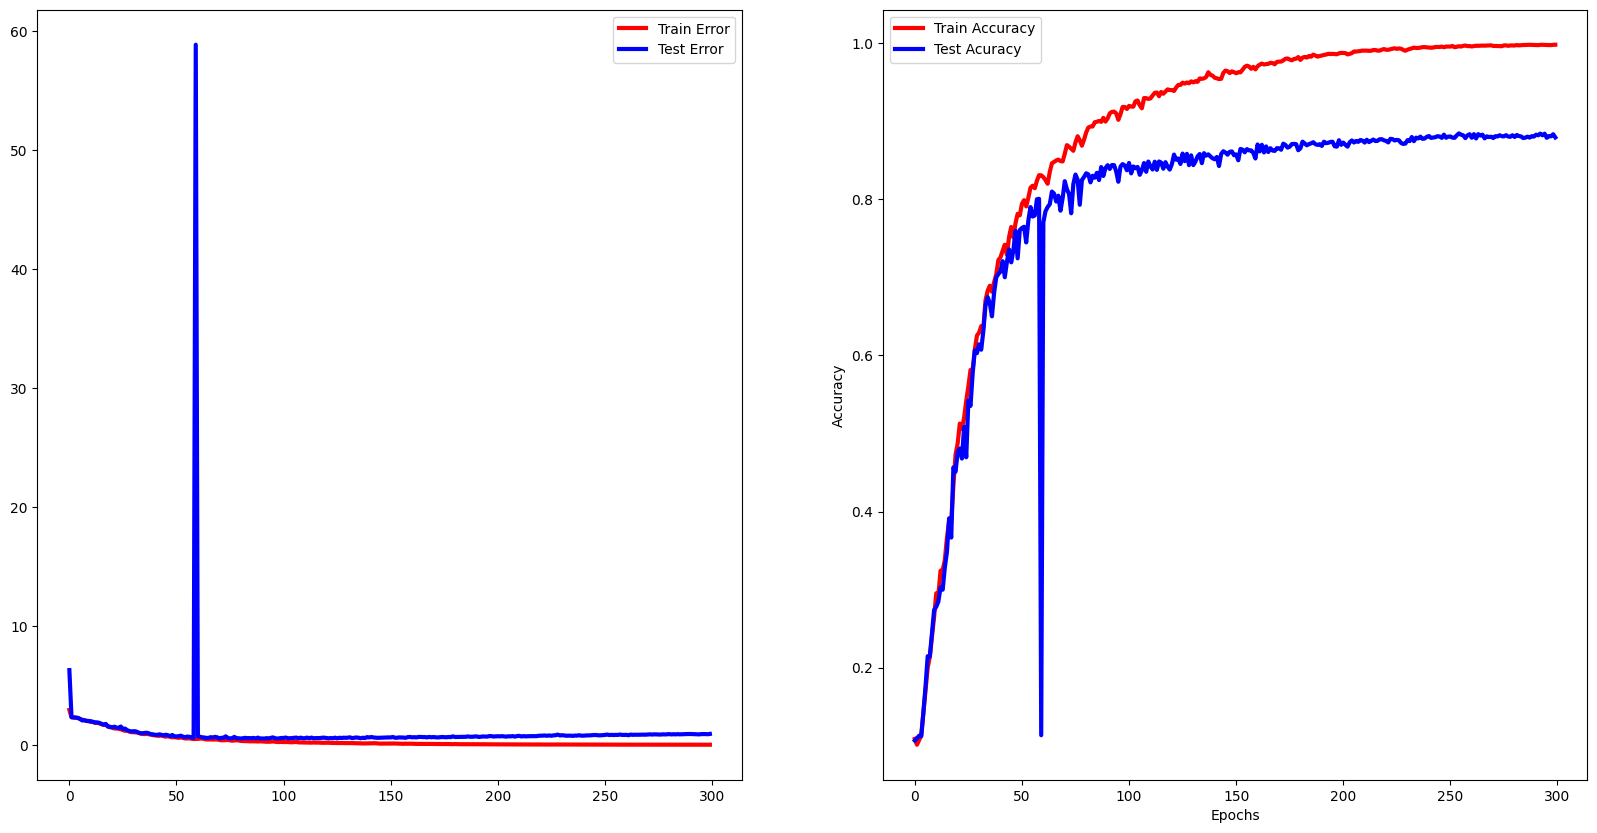

In [10]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error',color='Red')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error',color='Blue')

ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy',color='Red')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy',color='Blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

ax1.legend()
ax2.legend()
figure.savefig("./trainTestCurve.png")

In [11]:
corrects = 0.0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    output = torch.argmax(output, dim=1)
    corrects += torch.sum(labels == output).float().item()
print(corrects/len(test_loader.dataset))

0.8795


In [12]:
!pip install onnx
model = resnet_model()
model.load_state_dict(torch.load('./saved_model.pt'))
# set the model to evaluation mode 
model.eval() 

# Let's create a sample input tensor  
x = torch.randn(4, 3, 32, 32)

torch.onnx.export(model, x, "final_resnet_model.onnx", opset_version = 11)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 93.8 MB/s eta 0:00:00


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

